## Deskripsi Proyek

Proyek ini menganalisis tentang jumlah barang yang berhasil dipesan setiap bulan dan setiap waktunya. Setelah data dianalisis, akan dibuat model untuk memprediksi jumlah barang yang akan dibeli pada setiap bulan dan setiap 1 jam berikutnya.

## Konten
* [Deskripsi Proyek]
* [Import Libraries]
* [Import and Checking Dataset]
* [Memperbaiki Data]
* [EDA Time Series]
* [Pengecekan Outliers atau Nilai Ekstream]
* [Pembuatan Model]
    * [Linear Regression]
    * [Random Forest Regression]
    * [LightGBM]
* [Kesimpulan]

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [3]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

## Import and Checking Datasets

In [4]:
df = pd.read_excel('D:/ds_project/online_retail.xlsx', index_col=None, sheet_name='Year 2010-2011')

In [5]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
# mengubah urutan pada kolom
df = df.reindex(columns=['InvoiceDate', 'Invoice','Customer ID', 'Country', 'StockCode', 'Description', 'Quantity', 'Price'])
df.head()

,InvoiceDate,Invoice,Customer ID,Country,StockCode,Description,Quantity,Price
0,2010-12-01 08:26:00,536365,17850.0,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55
1,2010-12-01 08:26:00,536365,17850.0,United Kingdom,71053,WHITE METAL LANTERN,6,3.39
2,2010-12-01 08:26:00,536365,17850.0,United Kingdom,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75
3,2010-12-01 08:26:00,536365,17850.0,United Kingdom,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39
4,2010-12-01 08:26:00,536365,17850.0,United Kingdom,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39


In [7]:
# memeriksa informasi pada dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceDate  541910 non-null  datetime64[ns]
 1   Invoice      541910 non-null  object        
 2   Customer ID  406830 non-null  float64       
 3   Country      541910 non-null  object        
 4   StockCode    541910 non-null  object        
 5   Description  540456 non-null  object        
 6   Quantity     541910 non-null  int64         
 7   Price        541910 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [8]:
# memeriksa data yang hilang
df.isna().sum()

InvoiceDate         0
Invoice             0
Customer ID    135080
Country             0
StockCode           0
Description      1454
Quantity            0
Price               0
dtype: int64

In [9]:
# memeriksa data duplikat
df.duplicated().sum()

5268

In [10]:
# deskripsi data
df.describe()

,Customer ID,Quantity,Price
count,406830.000000,541910.000000,541910.000000
mean,15287.684160,9.552234,4.611138
std,1713.603074,218.080957,96.759765
min,12346.000000,-80995.000000,-11062.060000
25%,13953.000000,1.000000,1.250000
50%,15152.000000,3.000000,2.080000
75%,16791.000000,10.000000,4.130000
max,18287.000000,80995.000000,38970.000000


Data di atas memiliki nilai yang hilang pada kolom **Customer ID** dan **Description**. Pada kolom tersebut akan diisi dengan nilai unknown. Karena kita akan memprediksi penjualan produk di masa depan.

Berdasarkan deskripsi pada data, pada kolom **Quantity** dan kolom **Price** memiliki nilai yang tidak masuka akal, yaitu ada nilai yang negatif. Nilai tersebut akan diubah menjadi positif, karena untuk jumlah dan harga tidak ada nilai yang bernilai negatif.

Terdapat juga kolom yang terduplikat. Data tersebut akan dihapus untuk memudahkan analisis dan pemodelan.

## Memperbaiki Data

In [11]:
# memperbaiki kolom Customer ID dan Description
df['Customer ID'] = df['Customer ID'].fillna('unknown')
df['Description'] = df['Description'].fillna('unknown')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceDate  541910 non-null  datetime64[ns]
 1   Invoice      541910 non-null  object        
 2   Customer ID  541910 non-null  object        
 3   Country      541910 non-null  object        
 4   StockCode    541910 non-null  object        
 5   Description  541910 non-null  object        
 6   Quantity     541910 non-null  int64         
 7   Price        541910 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [13]:
# menghapus duplikat
df = df.drop_duplicates()

In [14]:
# pengecekan data duplikat
df.duplicated().sum()

0

In [15]:
# menjadikan kolom InvoiceDate sebagai index
df = df.set_index('InvoiceDate')

In [16]:
df.head()

,Invoice,Customer ID,Country,StockCode,Description,Quantity,Price
InvoiceDate,,,,,,,
2010-12-01 08:26:00,536365,17850.0,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55
2010-12-01 08:26:00,536365,17850.0,United Kingdom,71053,WHITE METAL LANTERN,6,3.39
2010-12-01 08:26:00,536365,17850.0,United Kingdom,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75
2010-12-01 08:26:00,536365,17850.0,United Kingdom,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39
2010-12-01 08:26:00,536365,17850.0,United Kingdom,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39


Karena data pada kolom **Invoice** adalah data angka yang menandakan setiap transaksi secara unik. Jika terdapat huruf **C** pada kolom **Invoice** maka transaksi tersebut gagal. Maka dari itu kita tidak akan mengambil data dengan status transaksi yang gagal.

In [17]:
# jumlah invoice dengan huruf C
df['Invoice'].str.contains('C').sum()

9251

In [18]:
'''
Karena kolom invoice terdapat nilai yang bukan object atau masih dalam bentuk string, 
maka akan diubah tipe datanya menjadi string.
'''
df['Invoice'] = df['Invoice'].astype('str')

In [19]:
# fungsi untuk memberikan status transaksi
def failed_transaction(invoice):
    if 'C' in invoice:
        return 'failed transaction'
    else:
        return 'success'

In [20]:
# menerapkan fungsi pada series Invoice
df['Transaction Status'] = df['Invoice'].apply(failed_transaction)

In [21]:
df.head()

,Invoice,Customer ID,Country,StockCode,Description,Quantity,Price,Transaction Status
InvoiceDate,,,,,,,,
2010-12-01 08:26:00,536365,17850.0,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,success
2010-12-01 08:26:00,536365,17850.0,United Kingdom,71053,WHITE METAL LANTERN,6,3.39,success
2010-12-01 08:26:00,536365,17850.0,United Kingdom,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,success
2010-12-01 08:26:00,536365,17850.0,United Kingdom,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,success
2010-12-01 08:26:00,536365,17850.0,United Kingdom,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,success


In [22]:
df[df['Transaction Status']=='failed transaction']

,Invoice,Customer ID,Country,StockCode,Description,Quantity,Price,Transaction Status
InvoiceDate,,,,,,,,
2010-12-01 09:41:00,C536379,14527.0,United Kingdom,D,Discount,-1,27.50,failed transaction
2010-12-01 09:49:00,C536383,15311.0,United Kingdom,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,4.65,failed transaction
2010-12-01 10:24:00,C536391,17548.0,United Kingdom,22556,PLASTERS IN TIN CIRCUS PARADE,-12,1.65,failed transaction
2010-12-01 10:24:00,C536391,17548.0,United Kingdom,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,0.29,failed transaction
2010-12-01 10:24:00,C536391,17548.0,United Kingdom,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,0.29,failed transaction
...,...,...,...,...,...,...,...,...
2011-12-09 09:57:00,C581490,14397.0,United Kingdom,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,0.83,failed transaction
2011-12-09 10:28:00,C581499,15498.0,United Kingdom,M,Manual,-1,224.69,failed transaction
2011-12-09 11:57:00,C581568,15311.0,United Kingdom,21258,VICTORIAN SEWING BOX LARGE,-5,10.95,failed transaction


In [23]:
df = df.drop(df[df['Transaction Status']=='failed transaction'].index)

In [24]:
df.shape

(510151, 8)

## EDA Time Series

Karena kita akan memprediksi jumlah pesanan yang akan terjadi di masa depan, maka kita akan mengambil data quantity saja.

In [25]:
# mengambil data quantity
df.sort_index(inplace=True)
df_quantity = df[['Quantity']]

In [26]:
df_quantity.head()

,Quantity
InvoiceDate,
2010-12-01 08:26:00,6
2010-12-01 08:26:00,6
2010-12-01 08:26:00,8
2010-12-01 08:26:00,6
2010-12-01 08:26:00,6


## Pengecekan Outliers atau Nilai Ekstream

<AxesSubplot:title={'center':'Quantity of Sales'}, xlabel='InvoiceDate'>

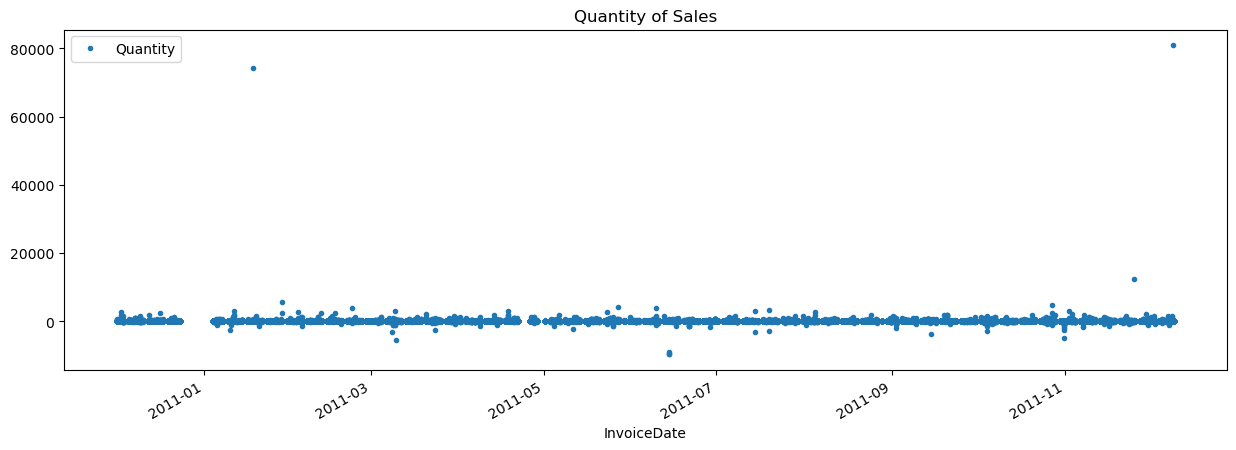

In [27]:
df_quantity.plot(style='.', figsize=(15,5), title='Quantity of Sales')

Menurut grafik di atas, terdapat banyak titik yang sangat jauh dari kebanyakan titik. Mungkin kita akan mengambil data di bawah 20.000. Terdapat banyak titik juga yang memiliki nilai negatif. Karena jumlah barang tidak negatif, maka data tersebut tidak akan diambil. Nilai negatif tersebut bisa jadi bentuk transaksi yang gagal yang tidak dicatat pada kolom **Invoice**.

<AxesSubplot:title={'center':'Quantity of Sales'}, xlabel='InvoiceDate'>

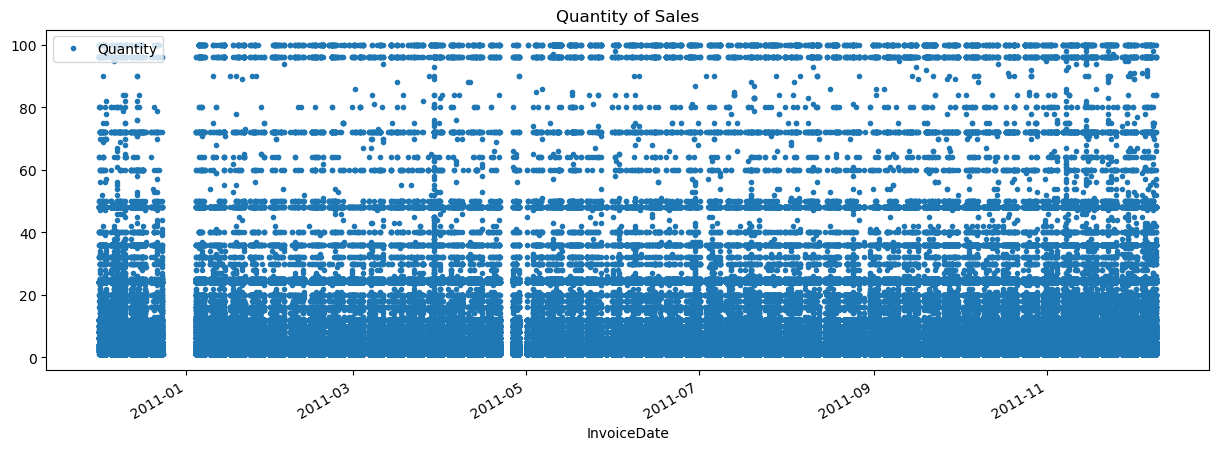

In [28]:
df_quantity.query('Quantity >= 0 and Quantity <= 100').plot(style='.', figsize=(15,5), title='Quantity of Sales')

In [29]:
df_sum = df_quantity.query('Quantity >= 0 and Quantity <= 100')

In [30]:
df_sum.shape

(504000, 1)

In [31]:
df_month = df_sum.resample('1M').sum()
df_month

,Quantity
InvoiceDate,
2010-12-31,265986
2011-01-31,239209
2011-02-28,205747
2011-03-31,275402
2011-04-30,228605
2011-05-31,299122
2011-06-30,290187
2011-07-31,301900
2011-08-31,303207


<AxesSubplot:xlabel='InvoiceDate'>

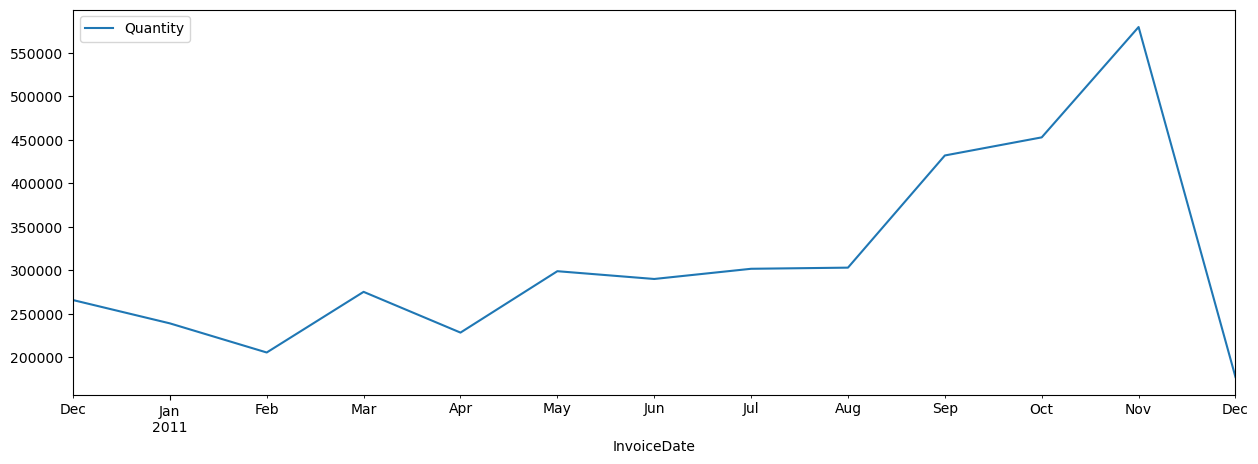

In [32]:
df_month.plot(figsize=(15,5))

Beerdasarkan grafik di atas, Terdapat nilai yang begitu tinggi pada jumlah pembelian online. Yaitu pada bulan Oktober. Sementara itu pada bulan Januari terdapat tanggal yang kosong akan pembeli.

In [33]:
# membuat moving average
df_month['moving_average'] = df_month['Quantity'].rolling(2).mean()

# membuat moving std 
df_month['rolling_std'] = df_month['Quantity'].rolling(2).std()

<AxesSubplot:xlabel='InvoiceDate'>

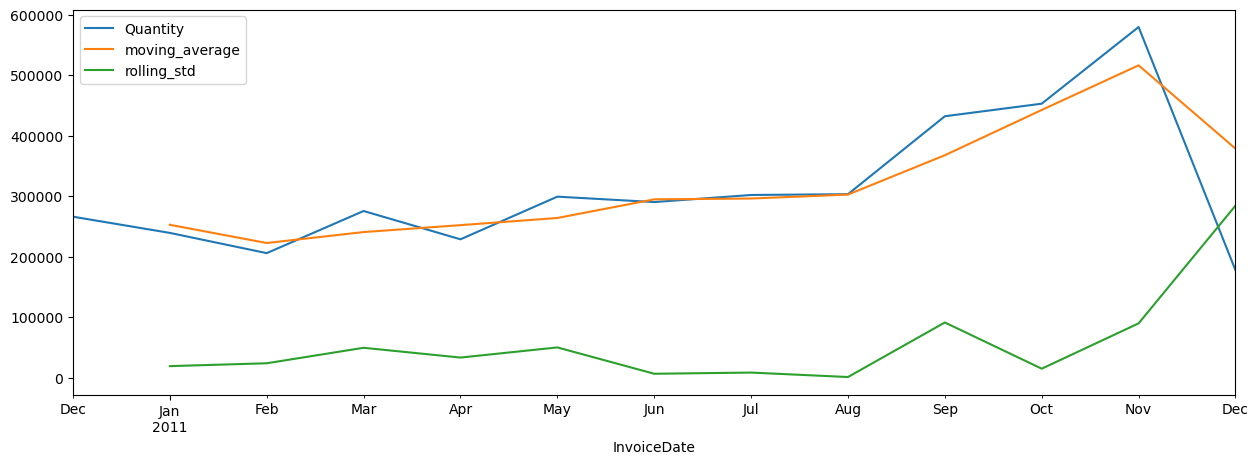

In [34]:
df_month.plot(figsize=(15,5))

Pada grafik di atas menunjukkan bahwa puncak paling banyak terjadinya pembelian online adalah pada bulan November dan pada bulan Desember terjadi penurunan drastis pada pembelian. Sebelum bulan November juga jumlah pembelian online terbilang normal.

In [35]:
# mengambil data 1 jam
df_hour = df_sum.resample('1H').sum()

In [36]:
df_hour.head()

,Quantity
InvoiceDate,
2010-12-01 08:00:00,602
2010-12-01 09:00:00,1479
2010-12-01 10:00:00,2350
2010-12-01 11:00:00,2201
2010-12-01 12:00:00,2365


Karena bulan yang paling banyak terjadi pembelian adalah bulan Oktober, maka akan dilihat data perminggu pada Bulan Oktober.

In [37]:
# menagmbil data perminggu
data_spec_w = df_hour.loc['2011-10-16':'2011-10-22',:]

<AxesSubplot:xlabel='InvoiceDate'>

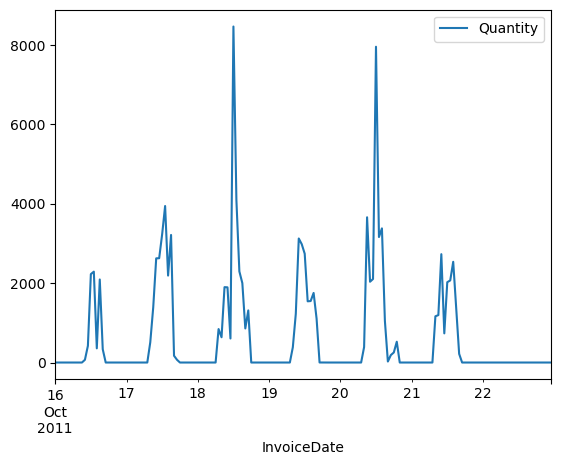

In [38]:
data_spec_w.plot()

In [39]:
# menambahkan moving average dan moving std pada data
data_spec_w['moving_average'] = data_spec_w['Quantity'].rolling(7).mean()
data_spec_w['moving_std'] = data_spec_w['Quantity'].rolling(7).std()

<AxesSubplot:xlabel='InvoiceDate'>

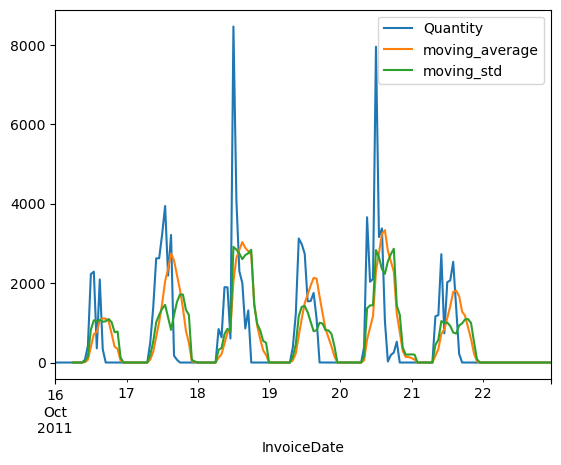

In [40]:
data_spec_w.plot()

Seperti yang terlihat pada grafik, ada dua hari yang mana penjualan sangat tinggi ada juga grafik yang sangat datar.Namun belum terlihat pada jam berapa penjualan mulai naik pada setiap hari dalam satu minggu.

Text(0, 0.5, 'Amount Order')

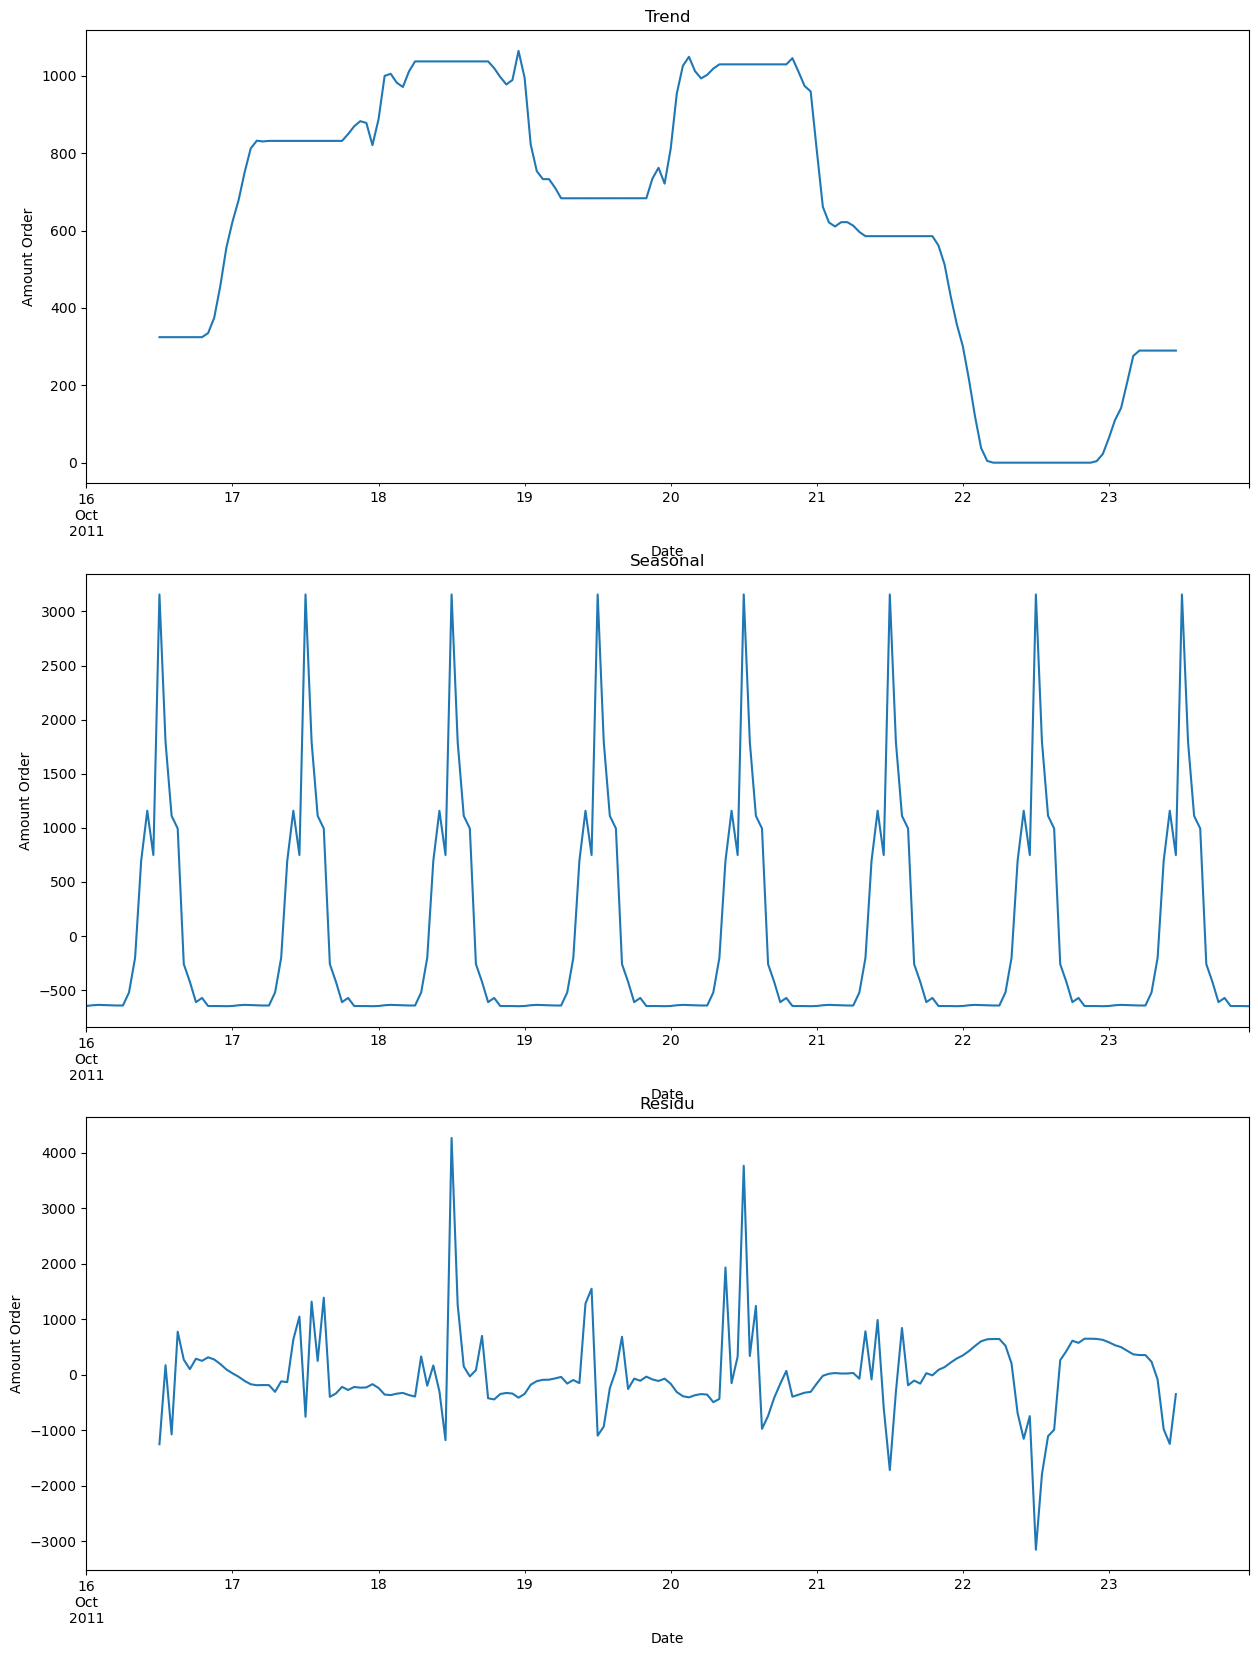

In [41]:
decomposed = seasonal_decompose(df_hour['2011-10-16':'2011-10-23'])

plt.figure(figsize=(15, 20))
# membuat grafik trend
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel('Date')
plt.ylabel('Amount Order')
# # membuat grafik seasonal
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')
plt.xlabel('Date')
plt.ylabel('Amount Order')
# # membuat grafik residu
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residu')
plt.xlabel('Date')
plt.ylabel('Amount Order')

Pada grafik **trend** menunjukkan tingkat trend yang naik turun dengan konstan. Setiap satu hari ada hari di mana terjadi pemerosotan grafik.

Pada grafik **seasonality** menunjukkan bahwa fluktuasi yang terjadi setiap satu hari adalah sama. Pola pada grafik juga sama.

Grafik **residu** menunjukkan grafik yang kita memiliki stationer dan perubahan polanya tidak bergantung oleh waktu.

Selanjutnya kita akan melihat data satu hari untuk melihat pada jam berapa biasanya orang mulai untuk berbelanja. Pada kasus inin kita akan mengambil data yang paling banyak terjadi pembelian yaitu pada bulan Oktober tanggal 18.

In [42]:
data_spec_d = df_hour.loc['2011-10-18', :].resample('1H').sum()
data_spec_d['moving_average'] = data_spec_d['Quantity'].rolling(7).mean()
data_spec_d['moving_std'] = data_spec_d['Quantity'].rolling(7).std()

<AxesSubplot:xlabel='InvoiceDate'>

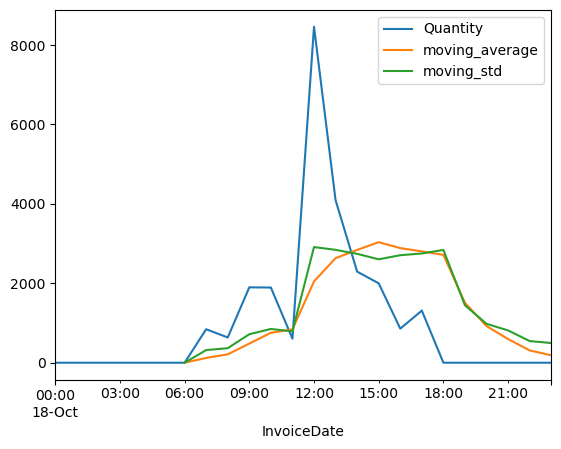

In [43]:
data_spec_d.plot()

Ternyata, orang-orang melakukan pembelian pada jam 6 pagi sampai pada jam 6 sore dan puncaknya terdapat pada jam 12 siang. Bisa jadi pembelian terjadi mengikuti jam buka dan jam tutup toko.

**Kesimpulan Umum:** Pada saat melakukan EDA ada beberapa insights yang bisa ditemukan. Penjualan yang terjadi naik seiring dengan waktu. Bahkan ada hari di mana penjualan menjadi sangat naik yaitu pada jam 12 siang. Setiap minggu pasti ada hari di mana penjualan tidak dilakukan sama sekali dan juga ada waktu di mana tidak terjadi pembelian sama sekali. Pembelian terjadi ketika jam 6 pagi sampai pada jam 6 sore. Asumsinya mungkin toko yang sedang libur atau orang-orang yang tidak ingin berbelanja pada akhir weekend. 

## Pembuatan Model

In [44]:
# fungsi membuat fitur
def make_features(data, max_lag, rolling_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for i in range(1, max_lag+1):
        data['lag_{}'.format(i)] = data['Quantity'].shift(i)
    
    data['rolling_mean'] = data['Quantity'].shift().rolling(rolling_size).mean()

# menerapkan fungsi
make_features(df_hour, 7, 24)
df_hour.dropna(inplace=True)
df_hour.tail()

,Quantity,year,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
InvoiceDate,,,,,,,,,,,,,,
2011-12-09 08:00:00,2361,2011,12,9,8,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1143.375000
2011-12-09 09:00:00,1016,2011,12,9,9,4,2361.0,0.0,0.0,0.0,0.0,0.0,0.0,1232.416667
2011-12-09 10:00:00,5142,2011,12,9,10,4,1016.0,2361.0,0.0,0.0,0.0,0.0,0.0,988.666667
2011-12-09 11:00:00,992,2011,12,9,11,4,5142.0,1016.0,2361.0,0.0,0.0,0.0,0.0,1116.916667
2011-12-09 12:00:00,2170,2011,12,9,12,4,992.0,5142.0,1016.0,2361.0,0.0,0.0,0.0,1044.875000


In [45]:
# train test split
train, test = train_test_split(df_hour, test_size=0.2, shuffle=False, random_state=42)

# membuat features dan target
features_train = train.drop(['Quantity'], axis=1)
target_train = train['Quantity']
features_test = test.drop(['Quantity'], axis=1)
target_test = test['Quantity']

In [46]:
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(7146, 13)
(7146,)
(1787, 13)
(1787,)


### Fungsi RMSE

In [47]:
def calculate_rmse(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    return rmse
scorer = make_scorer(calculate_rmse, greater_is_better=False)

### Linear Regression

Linear regression dipakai sebagai base line atau sanity check terhadap model yang lain.

In [48]:
lr = LinearRegression()
lr.fit(features_train, target_train)
predict_train = lr.predict(features_train)
predict_test = lr.predict(features_test)

In [49]:
print("Nilai RMSE train set:", calculate_rmse(target_train, predict_train))
print("Nilai RMSE test set:", calculate_rmse(target_test, predict_test))

Nilai RMSE train set: 617.3565294990948
Nilai RMSE test set: 907.9695177939312


Pada hasil di atas, menunjukkan bahwa nilai RMSE pada train set lebih rendah dari pada nilai pada test set. 

### Random Forest Regressor

In [50]:
# simple hyperparameter tuning
for depth in range(1, 10):
    rfr = RandomForestRegressor(n_estimators=70, max_depth=depth, random_state=42)
    rfr_score = -cross_val_score(rfr, features_train, target_train, cv=5, scoring=scorer)
    print("Max Depth:", depth, "Skor:", rfr_score.mean())

Max Depth: 1 Skor: 603.0113367901511
Max Depth: 2 Skor: 553.129978857228
Max Depth: 3 Skor: 541.8325537636074
Max Depth: 4 Skor: 537.8099647955073
Max Depth: 5 Skor: 537.8726346624186
Max Depth: 6 Skor: 534.51997591013
Max Depth: 7 Skor: 536.5303488915908
Max Depth: 8 Skor: 538.475912144669
Max Depth: 9 Skor: 539.5395792972726


In [51]:
# testing Random Forest Regressor
rfr = RandomForestRegressor(n_estimators=70, max_depth=7, random_state=42)
%time rfr.fit(features_train, target_train)

Wall time: 1.42 s


RandomForestRegressor(max_depth=7, n_estimators=70, random_state=42)

In [52]:
%time predict_rfr = rfr.predict(features_test)
print("Nilai RMSE:", calculate_rmse(target_test, predict_rfr))

Wall time: 64.5 ms
Nilai RMSE: 768.6834944200543


Pada model Random Forest Regressor, nilai RMSE pada data test set menunjukkan hasil yang lebih baik dibandingkan model Linear Regression.

### LightGBM

In [53]:
lgbm = LGBMRegressor()
params = {
    'num_leaves':[10, 20, 30],
    'learning_rate':[0.1, 0.5],
    'n_estimators':[50, 70],
    'objective':['rmse'],
    'random_seed':[42]
}
grid_cv = GridSearchCV(estimator=lgbm, param_grid=params, cv=5, n_jobs=-1)
grid_cv.fit(features_train, target_train)
best_params = grid_cv.best_params_

In [54]:
print("Parameter Terbaik:", best_params)
print("Skor Terbaik:", grid_cv.best_score_)

Parameter Terbaik: {'learning_rate': 0.1, 'n_estimators': 70, 'num_leaves': 10, 'objective': 'rmse', 'random_seed': 42}
Skor Terbaik: 0.5545238120180722


In [55]:
lgbm1 = LGBMRegressor(learning_rate=0.1, n_estimators=70, num_leaves=10, objective='rmse', random_seed=42)
%time lgbm1.fit(features_train, target_train)

Wall time: 188 ms


LGBMRegressor(n_estimators=70, num_leaves=10, objective='rmse', random_seed=42)

In [56]:
%time lgbm_predict = lgbm1.predict(features_test)
print('Skor RMSE:', calculate_rmse(target_test, lgbm_predict))

Wall time: 15 ms
Skor RMSE: 756.6315625119714


Karena kita memakai Gradient Boosting untuk memaksimalkan model. Maka hasil yang kita peroleh lebih bagus dari Random Forest Regressor.

## Kesimpulan

            RMSE
LR    907.969518
RFR   768.683494
LGBM  756.631563


<AxesSubplot:>

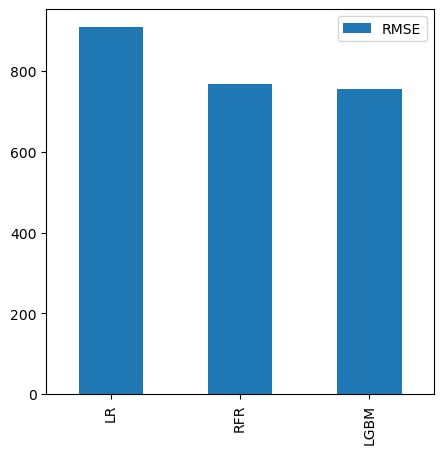

In [57]:
data = {
    'RMSE':[calculate_rmse(target_test, predict_test),
    calculate_rmse(target_test, predict_rfr),
    calculate_rmse(target_test,lgbm_predict)]
}

summary = pd.DataFrame(data=data, index=['LR', 'RFR', 'LGBM'])
print(summary)
summary.plot(kind='bar', figsize=(5, 5))

Analisis Data:
- Data yang diteliti adalah data online retail yang diambil dari tahun 2010 akhir sampai tahun 2011.
- Berdasarkan bulan, jumlah barang yang dibeli lebih banyak pada bulan Oktober menjelang akhir. Sedangkan mengalami pemerosotan pada bulan Desember.
- Berdasakran hari, tidak ada yang terlalu signifikan dalam kenaikan. Namun, penurunan pada setiap minggu itu terjadi pada akhir minggu. Jadi setiap akhir minggu tidak ada barang yang terjual sama sekali. Ada tanggal di mana memang tidak ada data penjualan sama sekali.
- Berdasarkan Jam, jam 12 adalah puncak di mana terjadi kelonjakan dalam pemesanan barang. Sedangkan jam di mana tidak ada jumlah barang yang dipesan ada pada jam 6 sore sampai jam 6 pagi.

Analisis Model:
- Model Linear Regression digunakan sebagai base line atau sanity check. Model ini mendapatka nilai RMSE sebesar 908 pada test set.
- Model Random Forest Regressor mendapatkan nilai RMSE sebesar 768 pada test set.
- Model LightGBM mendapatkan nilai RMSE sebesar 756 pada test set.
- Berdasarkan pemaparan tersebut, model yang bagus adalah LightGBM karena tingkat error yang begitu rendah daripada 2 model yang lain.